`TODO(lukasz): show that detected outliers (with Isolation Forest or (H)DBSCAN) can be used in finding incorrect labeled images`

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

We start from features extracted with `ResNet18` (pretrained on `ImageNet`).

In [2]:
X, y = np.load('../X_resnet18.npy'), np.load('../y_resnet18.npy')

## PCA

Principal component analysis (PCA) is a statistical procedure that uses an orthogonal transformation to convert a set of observations of possibly correlated variables (entities each of which takes on various numerical values) into a set of values of linearly uncorrelated variables called principal components. If there are $n$ observations with $p$  variables, then the number of distinct principal components is $\min(n - 1, p)$ . This transformation is defined in such a way that the first principal component has the largest possible variance (that is, accounts for as much of the variability in the data as possible), and each succeeding component in turn has the highest variance possible under the constraint that it is orthogonal to the preceding components. The resulting vectors (each being a linear combination of the variables and containing n observations) are an uncorrelated orthogonal basis set. PCA is sensitive to the relative scaling of the original variables.

In [3]:
from sklearn.decomposition import PCA

pca = PCA().fit(X)
X_pca_projection = pca.transform(X)

The total variance is the sum of variances of all individual principal components. The fraction of variance explained by a principal component is the ratio between the variance of that principal component and the total variance.

[Text(0, 0.5, 'Explained variance'), Text(0.5, 0, 'Number of components')]

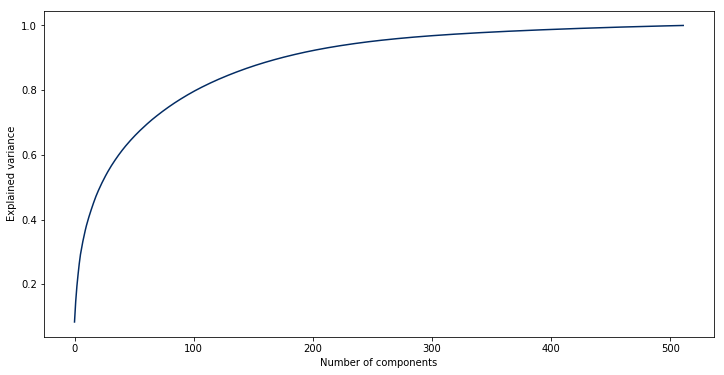

In [4]:
f, ax = plt.subplots(figsize=(12, 6))
ax.plot(np.cumsum(pca.explained_variance_ratio_), c='#032C64')
ax.set(xlabel='Number of components', ylabel='Explained variance')

Visualization of first two main components.

(-12.334161632083834,
 19.883730219737114,
 -13.49304408303001,
 13.63643266526934)

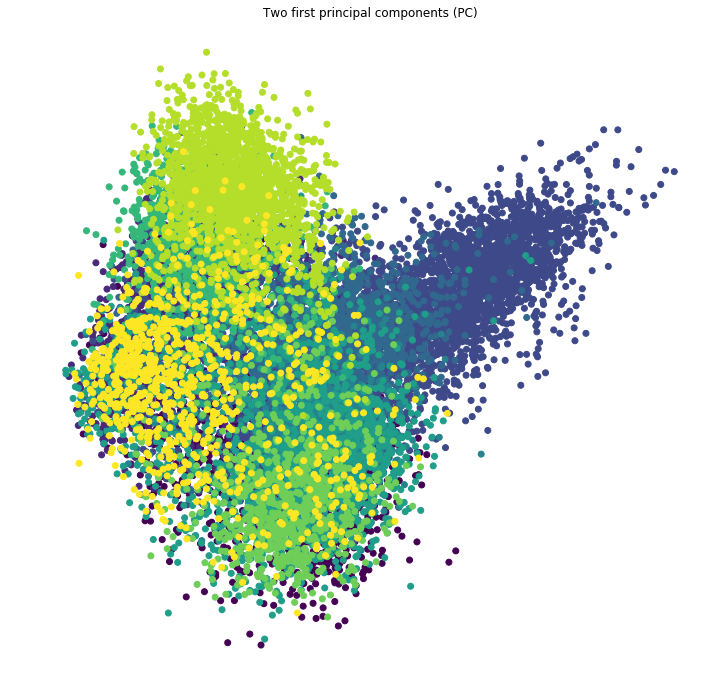

In [5]:
f, ax = plt.subplots(figsize=(12, 12))
ax.scatter(X_pca_projection[:, 0], X_pca_projection[:, 1], c=y)
ax.set(title='Two first principal components (PC)')
ax.axis('off')

## t-SNE

T-distributed Stochastic Neighbor Embedding (t-SNE) is a machine learning algorithm for visualization developed by Laurens van der Maaten and Geoffrey Hinton. It is a nonlinear dimensionality reduction technique well-suited for embedding high-dimensional data for visualization in a low-dimensional space of two or three dimensions. Specifically, it models each high-dimensional object by a two- or three-dimensional point in such a way that similar objects are modeled by nearby points and dissimilar objects are modeled by distant points with high probability.

The t-SNE algorithm comprises two main stages. First, t-SNE constructs a probability distribution over pairs of high-dimensional objects in such a way that similar objects have a high probability of being picked, whilst dissimilar points have an extremely small probability of being picked. Second, t-SNE defines a similar probability distribution over the points in the low-dimensional map, and it minimizes the Kullback–Leibler divergence between the two distributions with respect to the locations of the points in the map. Note that whilst the original algorithm uses the Euclidean distance between objects as the base of its similarity metric, this should be changed as appropriate.

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

pipe_tsne = Pipeline(steps=[
    ('pca', PCA(n_components=100)),
    ('tsne', TSNE(n_components=2, random_state=42))
])

With perplexity values in the range (5 - 50) suggested by van der Maaten & Hinton, the diagrams do show these clusters, although with very different shapes.

In [7]:
%%time
X_tsne = dict()
for perplexity in [5, 30, 50]:
    X_tsne[perplexity] = pipe_tsne.set_params(tsne__perplexity=perplexity)\
        .fit_transform(X)

CPU times: user 9min 30s, sys: 16.8 s, total: 9min 47s
Wall time: 9min 51s


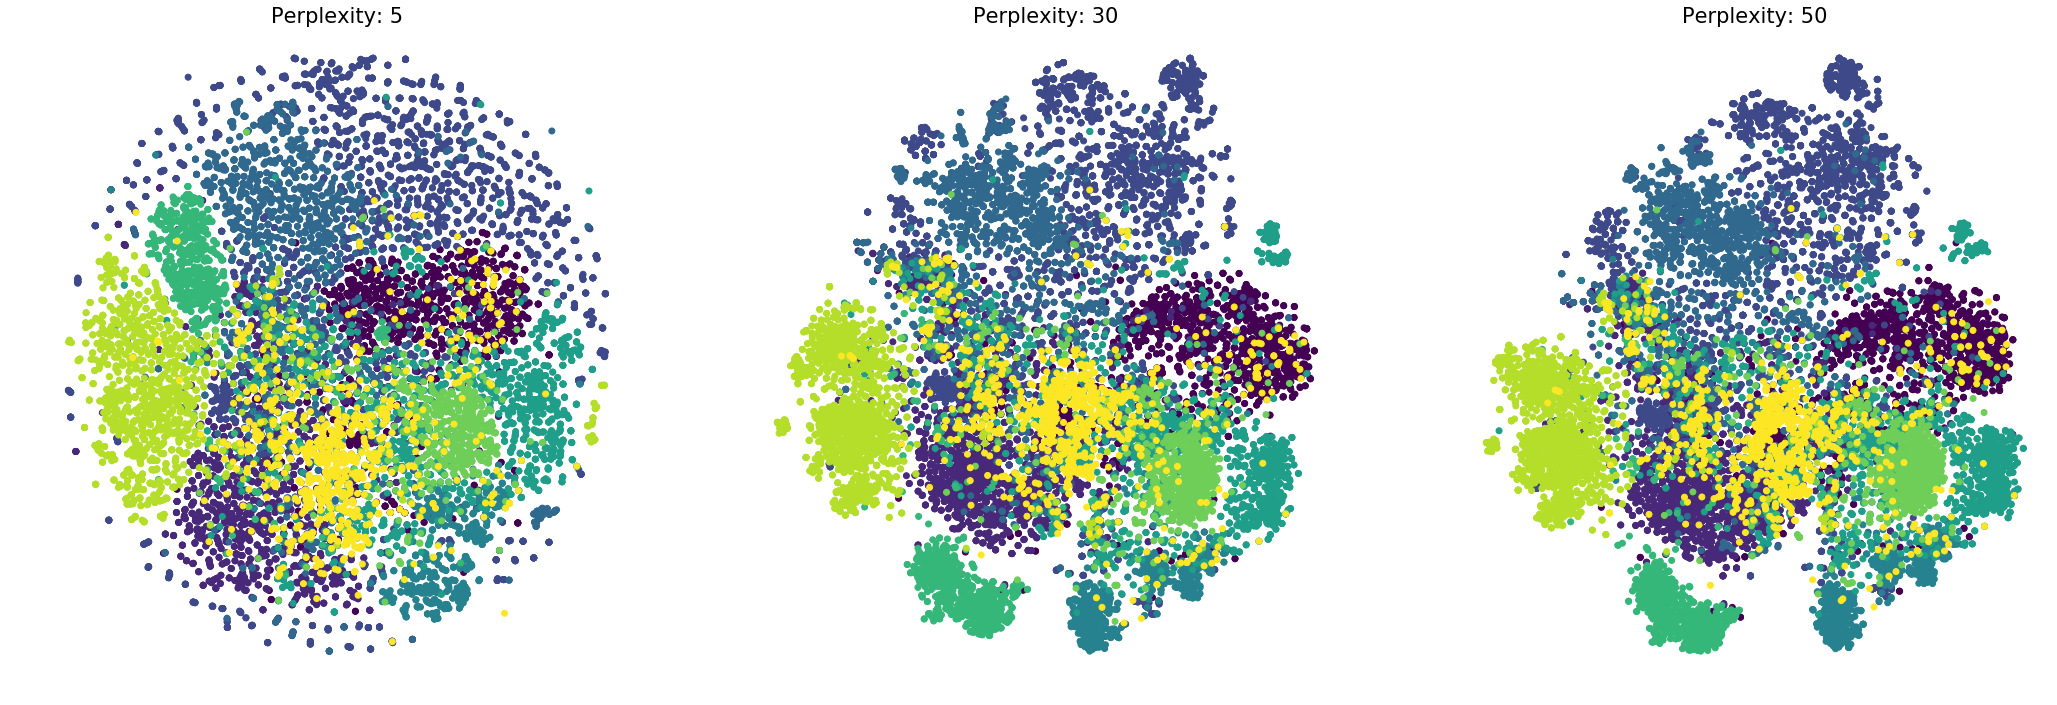

In [8]:
f, ax = plt.subplots(figsize=(36, 12), ncols=3)
for i, (perplexity, embeddings) in enumerate(X_tsne.items()):
    ax[i].scatter(embeddings[:, 0], embeddings[:, 1], c=y)
    ax[i].axis('off')
    ax[i].set_title('Perplexity: %d' % perplexity, fontsize=21)

## UMAP

Uniform Manifold Approximation and Projection (UMAP) is a dimension reduction technique that can be used for visualisation similarly to t-SNE, but also for general non-linear dimension reduction. The algorithm is founded on three assumptions about the data:

* the data is uniformly distributed on a Riemannian manifold,
* the Riemannian metric is locally constant (or can be approximated as such),
* the manifold is locally connected.

From these assumptions it is possible to model the manifold with a fuzzy topological structure. The embedding is found by searching for a low dimensional projection of the data that has the closest possible equivalent fuzzy topological structure.

    n_neighbors:
    This determines the number of neighboring points used in local approximations of manifold structure. Larger values will result in more global structure being preserved at the loss of detailed local structure. In general this parameter should often be in the range 5 to 50, with a choice of 10 to 15 being a sensible default.
    min_dist:
    This controls how tightly the embedding is allowed compress points together. Larger values ensure embedded points are more evenly distributed, while smaller values allow the algorithm to optimise more accurately with regard to local structure. Sensible values are in the range 0.001 to 0.5, with 0.1 being a reasonable default.

In [9]:
%%time
import umap
import itertools

X_umap = dict()
for idx, (n_neighbors, min_dist) in enumerate(itertools.product([5, 15, 50], [0.001, 0.1, 0.5])):
    X_umap[idx] = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, random_state=42, transform_seed=42)\
        .fit_transform(X)

/Users/lukaszambroziak/anaconda3/envs/tmle/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 44 separate connected components using meta-embedding (experimental)
  n_components
/Users/lukaszambroziak/anaconda3/envs/tmle/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 44 separate connected components using meta-embedding (experimental)
  n_components
/Users/lukaszambroziak/anaconda3/envs/tmle/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 44 separate connected components using meta-embedding (experimental)
  n_components


CPU times: user 2min 59s, sys: 13.9 s, total: 3min 13s
Wall time: 3min 3s


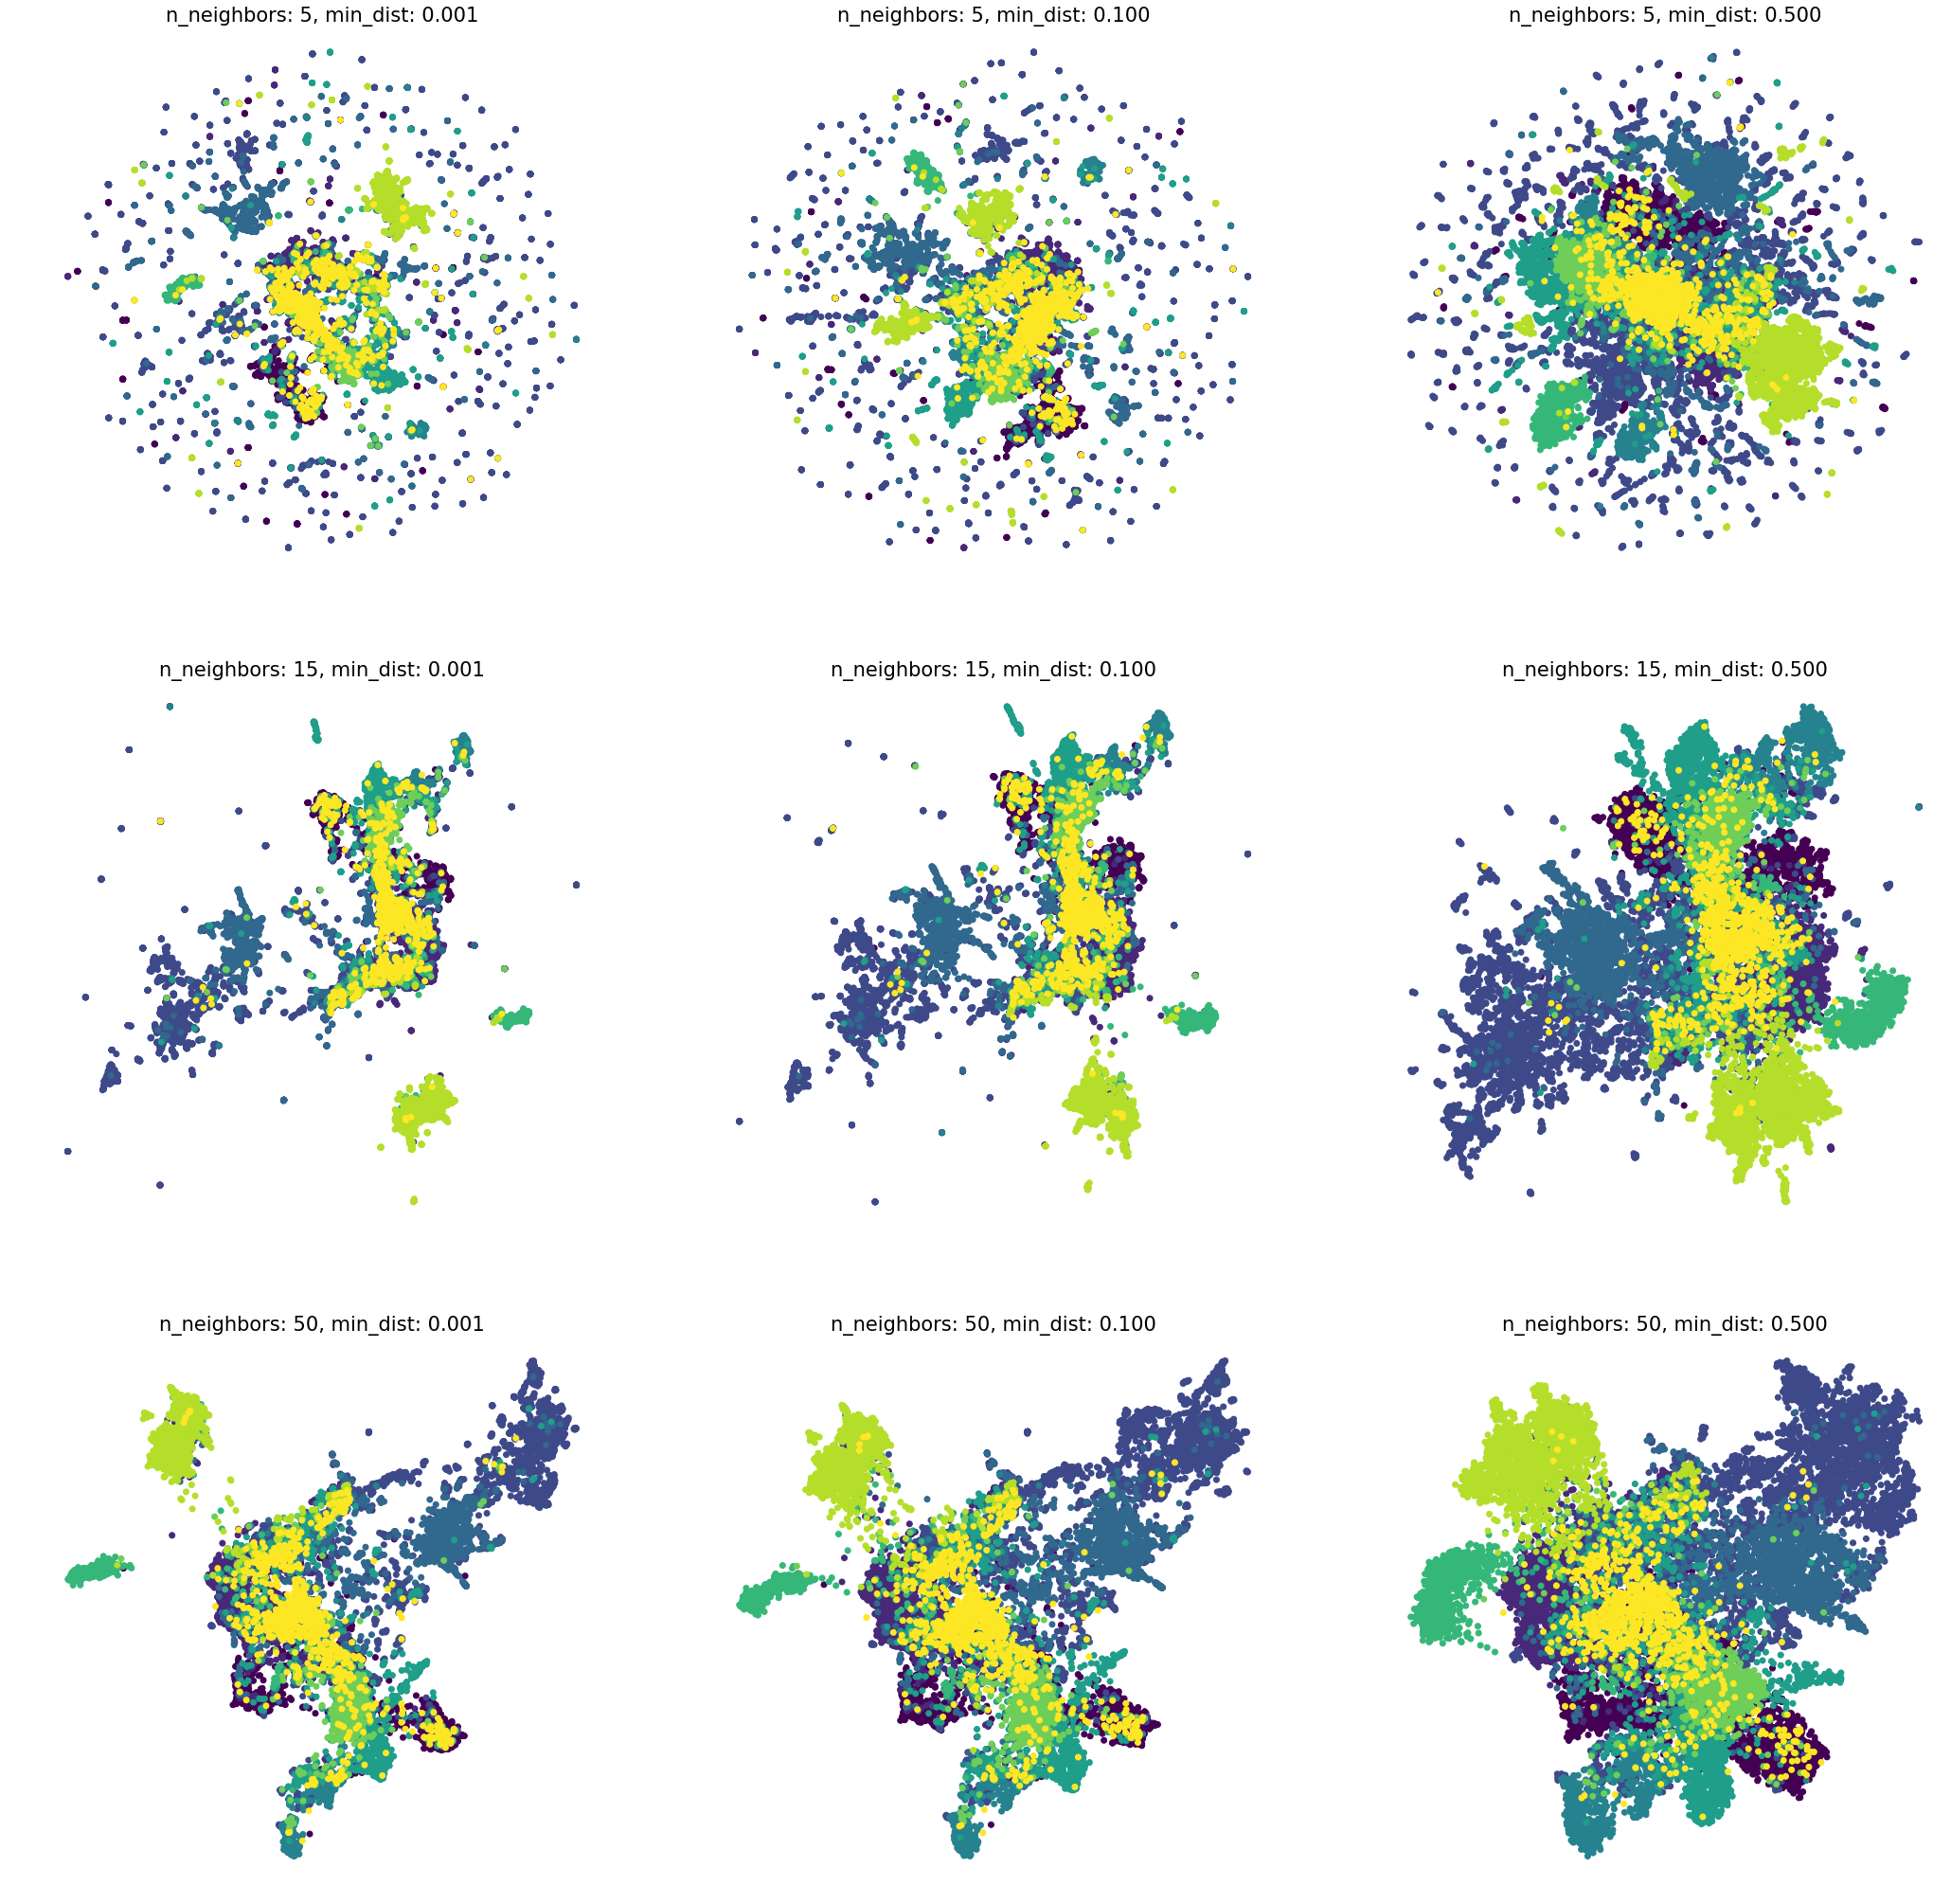

In [10]:
f, ax = plt.subplots(figsize=(36, 36), nrows=3, ncols=3)
ax = ax.flatten()
for (i, embeddings), (n_neighbors, min_dist) in zip(enumerate(X_umap.values()), itertools.product([5, 15, 50], [0.001, 0.1, 0.5])):
    ax[i].scatter(embeddings[:, 0], embeddings[:, 1], c=y)
    ax[i].axis('off')
    ax[i].set_title('n_neighbors: %d, min_dist: %.3f' % (n_neighbors, min_dist), fontsize=21)

# Summary

We used ... .